# Projet Name
* Description

# 0.0 Imports

In [1]:
import math
import inflection
import numpy                as np
import pandas               as pd
import datetime             as dt
import seaborn              as sns
import matplotlib.pyplot    as plt
from IPython.display import Image
from boruta import BorutaPy

# Endoders (pre-processors)
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

# ML models
import xgboost              as xgb
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.metrics        import mean_absolute_error, mean_squared_error


# Lib para não mostrar warnings de melhorias futuras (sugestão de novos comandos) das bibliotecas
import warnings
warnings.filterwarnings('ignore')

C:\Users\marci\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Help Functions

In [2]:
def jupyter_settings():

#
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = '78'
#
#    display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    
    
    sns.set(font_scale=1.5)

    
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = [] 
    rmse_list = []

    for k in reversed(range(1, 6)):
        if verbose == True:
            print('\nKfold Number {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - dt.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - dt.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE CV' : np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])



In [3]:
jupyter_settings()

# 1.0 Load Data

In [4]:
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)
df_train_raw = pd.read_csv('../data/train.csv', low_memory=False)

df_raw = pd.merge(df_train_raw, df_store_raw, how='left', on='Store')

# 2.0 Data Description

In [5]:
# Backup dos dados
df2 = df_raw.copy()

## 2.1 Rename Columns

In [6]:
# Nome antigo das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Alteração automática do nome das colunas, utilizando a função underscore da lib inflection
cols_new = list(map(lambda x: inflection.underscore(x), cols_old))

# Atribuição do novo nome
df2.columns = cols_new

df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
184439,465,1,2015-02-16,10880,712,1,1,0,0,d,c,10890.0,4.0,2005.0,0,NaN,NaN,NaN


## 2.2 Data Dimension

In [7]:
print(f'A quantidade de registros é {df2.shape[0]} linhas.')
print(f'A quantidade de features é {df2.shape[1]} colunas.')

A quantidade de registros é 1017209 linhas.
A quantidade de features é 18 colunas.


## 2.3 Data Types

In [8]:
# date para datetime
df2['date'] = pd.to_datetime(df2['date'])
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check NA's

In [9]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 Fillout NA

In [10]:
# Atribuição de distância 200000 para NA's
df2['competition_distance'].fillna(200000.0, inplace = True)

# Atribuição do mês da data original para NA's
df2['competition_open_since_month'] = df2.apply(lambda x: x['date'].month
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)

# Atribuição do ano da data original para NA's
df2['competition_open_since_year'] = df2.apply(lambda x: x['date'].year
                                              if math.isnan(x['competition_open_since_year'])
                                              else x['competition_open_since_year'], axis = 1)

# Atribuição de zero pois loja não participa da promo2
df2['promo2_since_week'].fillna(0, inplace= True)

# Atribuição de zero pois loja não participa da promo2
df2['promo2_since_year'].fillna(0, inplace= True)

# Atribuição de zero para NA's
df2['promo_interval'].fillna(0, inplace= True)


In [11]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 2.6 Change Types

In [12]:
# Alteração das variáveis de float64 para int64
df2['competition_distance'] = df2['competition_distance'].astype('int64')
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype('int64')
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype('int64')
df2['promo2_since_week'] = df2['promo2_since_week'].astype('int64')
df2['promo2_since_year'] = df2['promo2_since_year'].astype('int64')


In [13]:
df2.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
39423,399,5,2015-06-26,4793,504,1,0,0,0,a,a,5360,9,2012,1,40,2011,"Jan,Apr,Jul,Oct"
167962,713,2,2015-03-03,10478,1201,1,1,0,0,a,c,220,3,2015,1,10,2014,"Jan,Apr,Jul,Oct"
817066,557,6,2013-06-29,4267,736,1,0,0,0,a,a,250,6,2013,0,0,0,0
480463,684,7,2014-04-27,0,0,0,0,0,0,d,c,680,4,2014,1,22,2012,"Jan,Apr,Jul,Oct"
727442,133,2,2013-09-17,4569,692,1,0,0,0,a,a,270,8,2013,1,10,2014,"Mar,Jun,Sept,Dec"
961394,1050,3,2013-02-20,7320,501,1,1,0,0,d,c,13170,8,2014,1,9,2011,"Mar,Jun,Sept,Dec"
823094,1010,1,2013-06-24,6918,681,1,0,0,1,d,c,4610,6,2010,1,18,2010,"Feb,May,Aug,Nov"
356668,733,1,2014-08-25,14144,3346,1,0,0,0,b,b,860,10,1999,0,0,0,0
784745,571,7,2013-07-28,0,0,0,0,0,0,d,a,2110,11,1995,1,40,2014,"Jan,Apr,Jul,Oct"
483849,725,4,2014-04-24,5111,528,1,0,0,1,d,c,17540,6,2012,0,0,0,0


In [14]:
#r = df2[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()
#r['percent'] = r.apply(lambda x: 'day_of_week' / ('sales').sum())

## 2.7 Descriptive Statistical

### 2.7.1 Numerical Attributes


In [15]:
num_atrib = df2.select_dtypes(include=['float64', 'int64'])
cat_atrib = df2.select_dtypes(exclude=['float64', 'int64', 'datetime64'])

In [16]:
# Tendência Central
ct1 = pd.DataFrame(num_atrib.apply(np.mean)).T
ct2 = pd.DataFrame(num_atrib.apply(np.median)).T

# Dispersão -> std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_atrib.apply(np.std)).T
d2 = pd.DataFrame(num_atrib.apply(min)).T
d3 = pd.DataFrame(num_atrib.apply(max)).T
d4 = pd.DataFrame(num_atrib.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_atrib.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_atrib.apply(lambda x: x.kurtosis())).T

df2_num = pd.concat([d2, ct1, d3, d4, ct2, d1, d5, d6]).T.reset_index()

df2_num.columns = ['Atributos', 'Mínima', 'Média', 'Máximo', 'Range', 'Mediana', 'Desvio_Padrão', 'Skew', 'Kurtosis']

In [17]:
df2_num

,Atributos,Mínima,Média,Máximo,Range,Mediana,Desvio_Padrão,Skew,Kurtosis
0,store,1.0,558.429727,1115.0,1114.0,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,3.998341,7.0,6.0,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,5773.818972,41551.0,41551.0,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,633.145946,7388.0,7388.0,609.0,464.411506,1.598650,7.091773
4,open,0.0,0.830107,1.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,0.381515,1.0,1.0,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,0.178647,1.0,1.0,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,5935.442677,200000.0,199980.0,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,6.786849,12.0,11.0,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2010.324840,2015.0,115.0,2012.0,5.515591,-7.235657,124.071304


### 2.7.2 Categorical Attributes

In [18]:
res = cat_atrib.apply(lambda x: x.unique().shape[0])
res

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

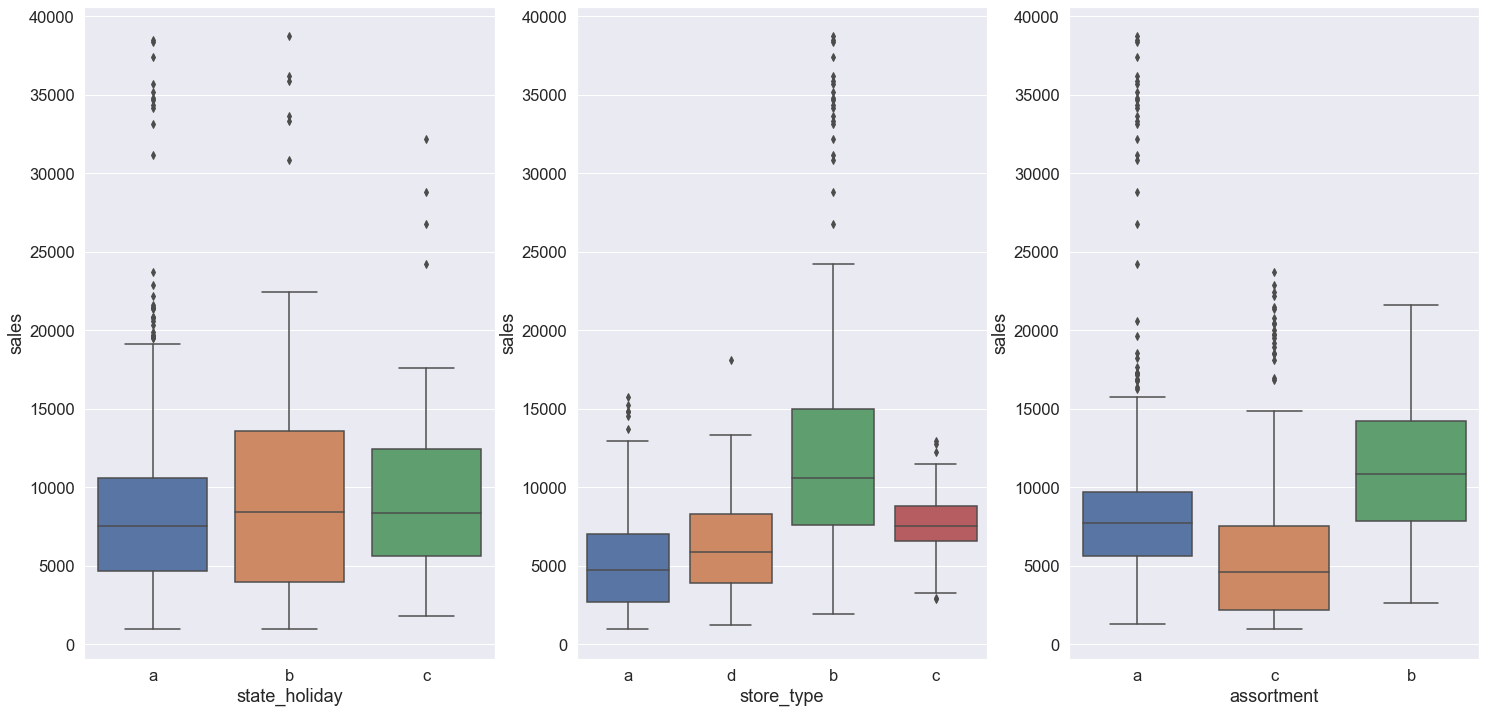

In [19]:
aux1 = df2[(df2['state_holiday'] != '0') & (df2['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);



In [20]:
# State Holiday 
#a = public holiday, b = Easter holiday, c = Christmas
# Conclusão: Mesmo o public holiday (a) tendo mais dias do que os outros feriados, o Easter Holiday (b) possui
# maior volume de vendas

# Store Type
# Conclusão: A loja B possui volume de vendas com maior valor de vendas, em compraração as outras lojas. A loja do tipo C
# possui valor de venda maior do que A e D mas com pouco volume.


# Assortment
# a = basic, b = extra, c = extended
# Conclusão: Os produtos Extra (b) possuem maior volume de vendas e são melhor distribuídos entre as vendas, enquanto
# que os outros itens, há muitas vendas concentradas em torno do valor da mediana (basic) ou valores baixos (extended)


# 3.0 Feature Engineering 

In [21]:
# Backup dos dados
df3 = df2.copy()

## 3.1 Mapa Mental Hipóteses

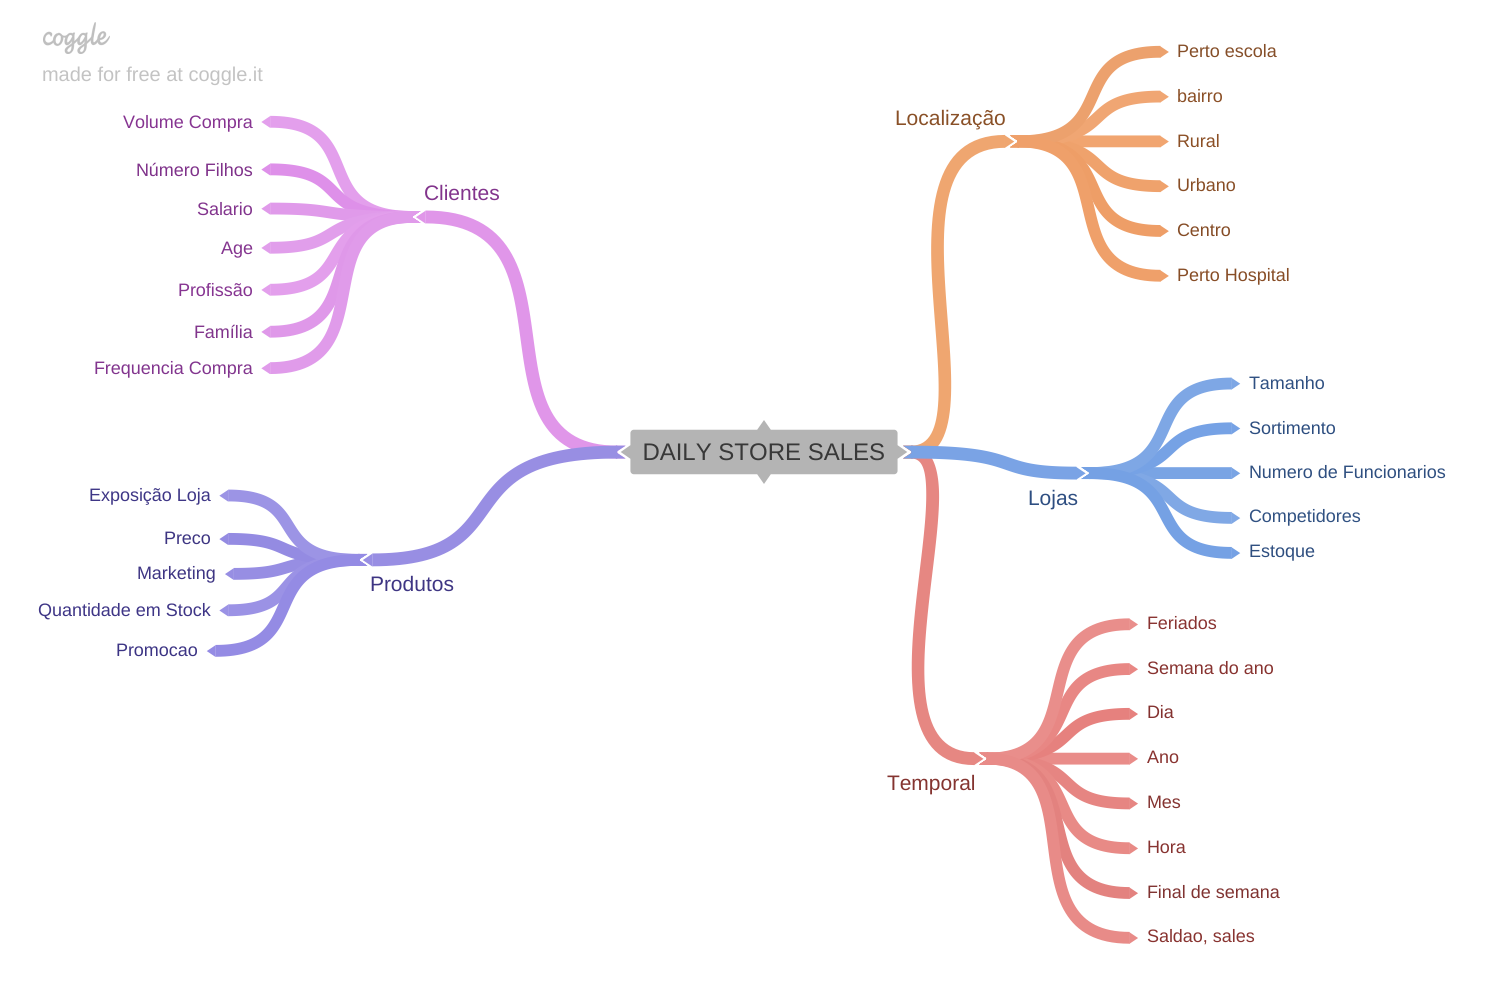

In [22]:
Image('../img/MindMapHypothesis.png')

## 3.2 HIPÓTESES


3.1.0 Lojas

    1.1 Lojas com mais clientes tiveram faturamento maior

    1.2 Lojas com promoção contínua (mais tempo) vendem mais

3.2.0 Clientes
    
    2.1 Clientes que compram mais são os que gastam mais, na média

3.3.0 Vendas
    
    3.1 As vendas são maiores quando o feriado cai na sexta (5 dia da semana)
    3.2 As vendas são maiores antes do feriado em comparação ao dia depois do feriado




## 3.3 Feature Engineering

In [23]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week_of_year
df3['week_of_year'] = df3['date'].dt.isocalendar().week.astype('int64')

# year_week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x == 'b' else
                                                      'extended')

df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                            'easter_holiday' if x == 'b' else
                                                            'christmas' if x == 'c' else
                                                            'regular_day')

# Média de vendas por cliente, por dia
df3['ticket_medio'] = df3.apply(lambda x: x['sales'] / x['customers'] if x['sales'] > 0 else x['sales'], axis=1 )



In [24]:
r = df3[df3['state_holiday'] == 'easter_holiday']
r['date'].unique()

array(['2015-04-06T00:00:00.000000000', '2015-04-03T00:00:00.000000000',
       '2014-04-21T00:00:00.000000000', '2014-04-18T00:00:00.000000000',
       '2013-04-01T00:00:00.000000000', '2013-03-29T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [25]:
df3.sample(15)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo2,promo2_since_week,promo2_since_year,promo_interval,year,month,day,week_of_year,year_week,ticket_medio
138827,568,7,2015-03-29,0,0,0,0,regular_day,0,d,...,1,1,2013,"Jan,Apr,Jul,Oct",2015,3,29,13,2015-12,0.000000
960682,338,3,2013-02-20,10135,810,1,1,regular_day,0,a,...,1,37,2009,"Jan,Apr,Jul,Oct",2013,2,20,8,2013-07,12.512346
242194,250,4,2014-12-25,0,0,0,0,christmas,1,d,...,1,18,2012,"Feb,May,Aug,Nov",2014,12,25,52,2014-51,0.000000
820625,771,3,2013-06-26,5146,581,1,0,regular_day,0,a,...,0,0,0,0,2013,6,26,26,2013-25,8.857143
187682,363,5,2015-02-13,6287,852,1,0,regular_day,0,a,...,0,0,0,0,2015,2,13,7,2015-06,7.379108
890927,828,3,2013-04-24,4784,582,1,1,regular_day,0,d,...,0,0,0,0,2013,4,24,17,2013-16,8.219931
125720,841,5,2015-04-10,2690,416,1,0,regular_day,1,a,...,0,0,0,0,2015,4,10,15,2015-14,6.466346
1004647,818,6,2013-01-12,4229,501,1,0,regular_day,0,d,...,1,35,2010,"Mar,Jun,Sept,Dec",2013,1,12,2,2013-01,8.441118
454994,860,2,2014-05-20,5992,737,1,1,regular_day,0,c,...,0,0,0,0,2014,5,20,21,2014-20,8.130258
557690,976,1,2014-02-17,10302,1007,1,1,regular_day,0,a,...,0,0,0,0,2014,2,17,8,2014-07,10.230387


# 4.0 Data Filtering

In [26]:
df4 = df3.copy()

In [27]:
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)] # & (df4['promo2_since_week'] > 0) & (df4['promo2_since_year'] > 0)]

In [28]:
cols_drop=['open', 'promo_interval']
df4 = df4.drop(cols_drop, axis=1)

In [29]:
num_atrib = df4.select_dtypes(include=['float64', 'int64'])
cat_atrib = df4.select_dtypes(exclude=['float64', 'int64', 'datetime64'])

In [30]:
df4.sample(10)

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,...,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,ticket_medio
540357,368,2,2014-03-04,4990,336,1,regular_day,0,d,extended,...,2005,1,45,2009,2014,3,4,10,2014-09,14.851190
304368,802,1,2014-10-20,7839,555,1,regular_day,1,a,extended,...,2014,1,22,2011,2014,10,20,43,2014-42,14.124324
161485,926,1,2015-03-09,5638,475,0,regular_day,0,d,extended,...,2011,1,13,2010,2015,3,9,11,2015-10,11.869474
787362,958,5,2013-07-26,4051,536,0,regular_day,1,a,basic,...,2013,0,0,0,2013,7,26,30,2013-29,7.557836
188510,76,4,2015-02-12,7808,807,0,regular_day,0,d,extended,...,2006,0,0,0,2015,2,12,7,2015-06,9.675341
880331,267,5,2013-05-03,9327,1091,1,regular_day,0,c,basic,...,2012,0,0,0,2013,5,3,18,2013-17,8.549038
150671,147,3,2015-03-18,8290,909,1,regular_day,0,d,extended,...,2015,0,0,0,2015,3,18,12,2015-11,9.119912
539097,223,3,2014-03-05,9358,899,1,regular_day,0,d,extended,...,1995,1,27,2011,2014,3,5,10,2014-09,10.409344
283280,188,2,2014-11-11,5993,479,1,regular_day,0,d,basic,...,2014,1,18,2011,2014,11,11,46,2014-45,12.511482
650427,53,1,2013-11-25,6329,624,0,regular_day,0,a,extended,...,2013,0,0,0,2013,11,25,48,2013-47,10.142628


# 5.0 EDA

In [31]:
df5 = df4.copy()

## 5.1 Univariate Analysis

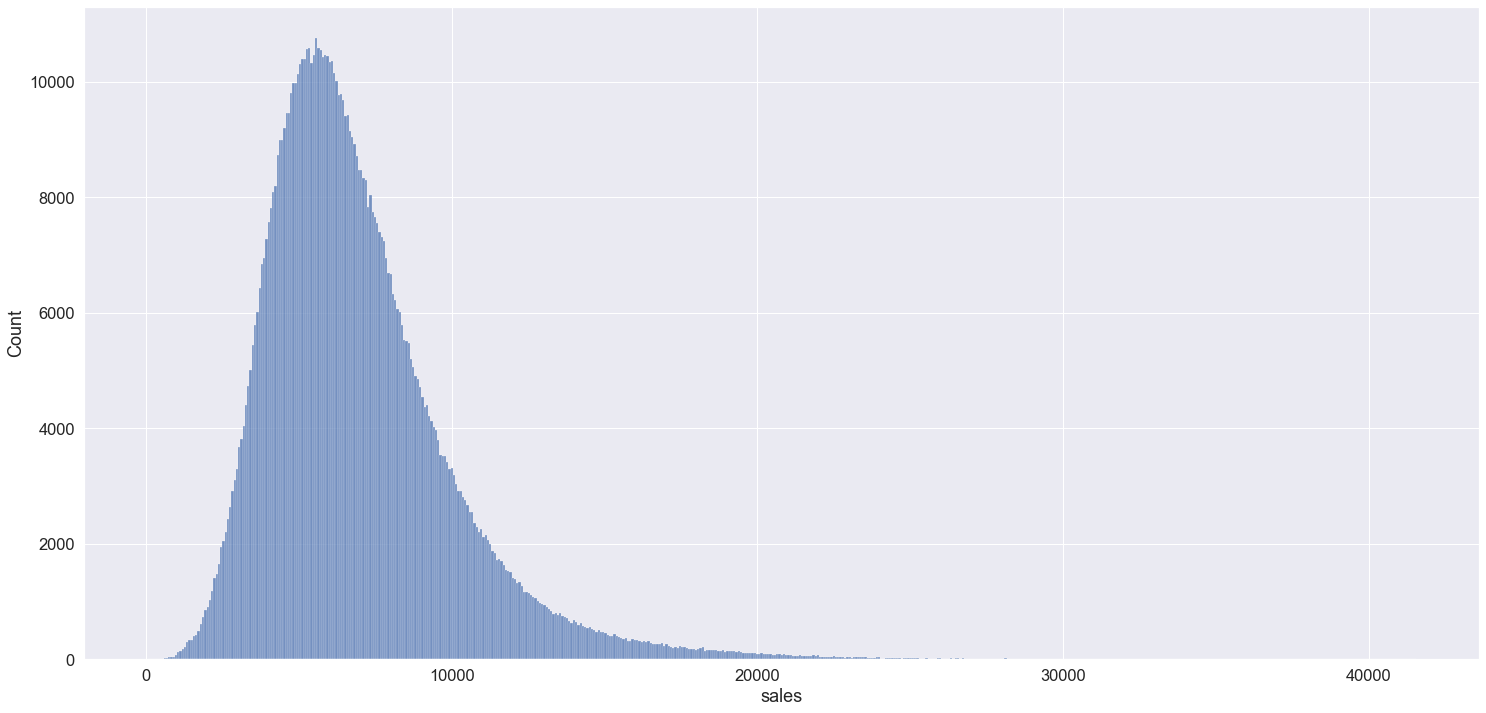

In [32]:
sns.histplot(df5['sales']);

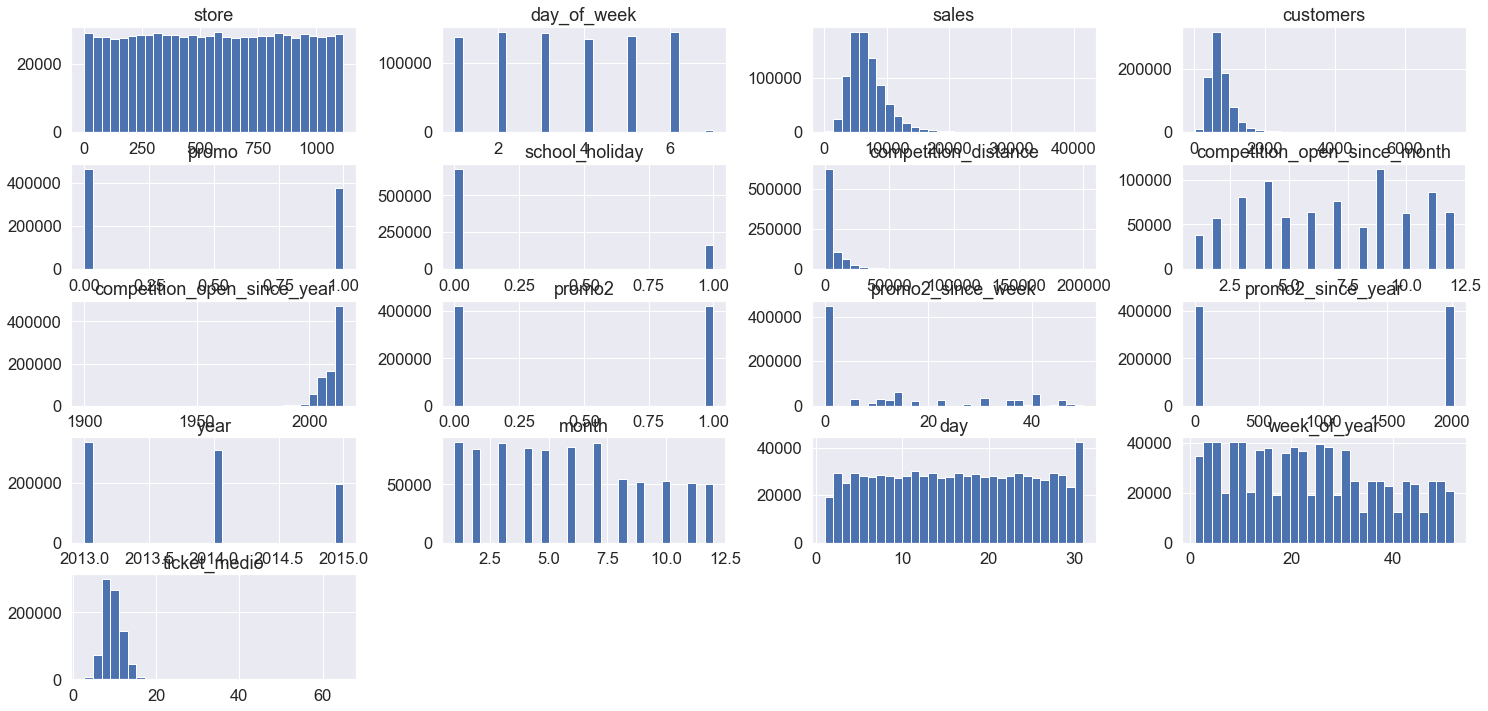

In [33]:
num_atrib.hist(bins=30);

## 5.2 Bivariate Analysis

### H1 Lojas com mais clientes tiveram faturamento maior

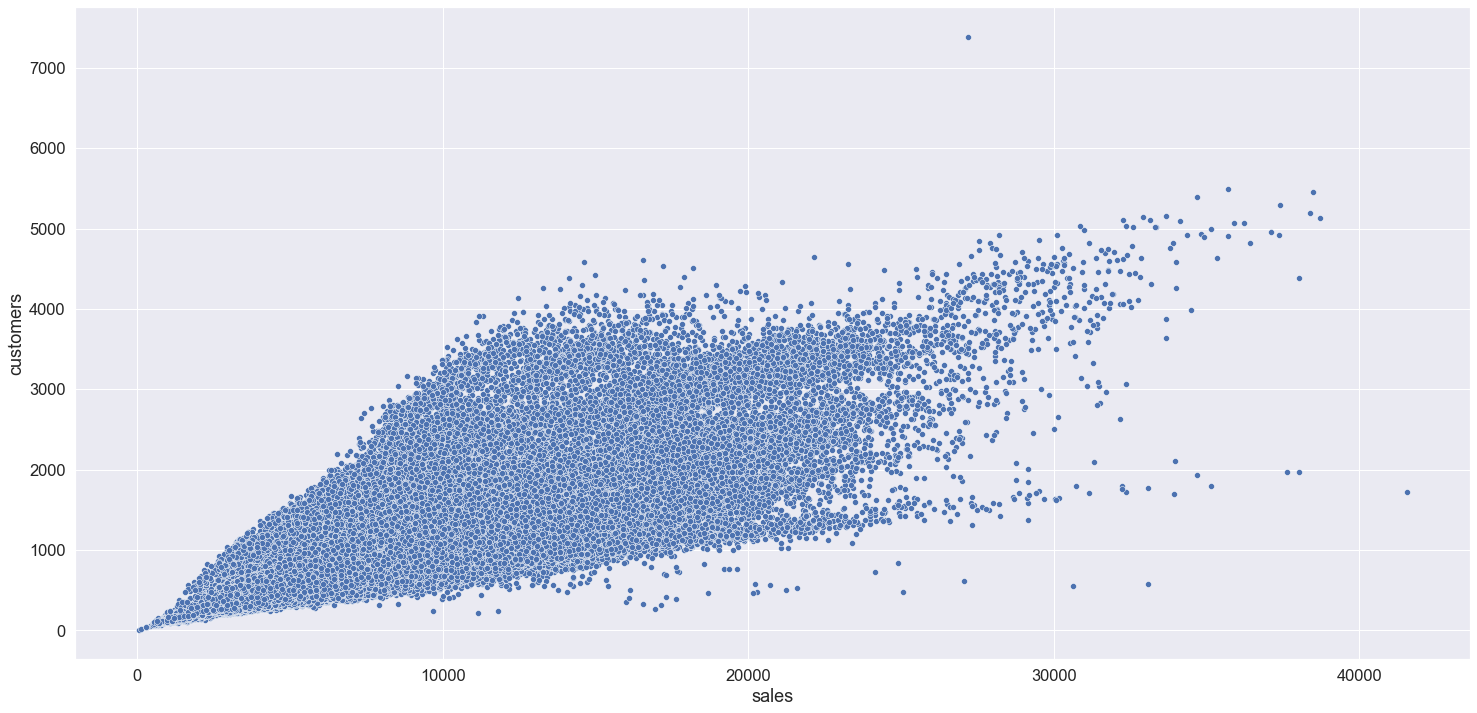

In [34]:
sns.scatterplot(x='sales', y='customers', data=df5);

### H2 Lojas com promoção contínua (mais tempo) vendem mais

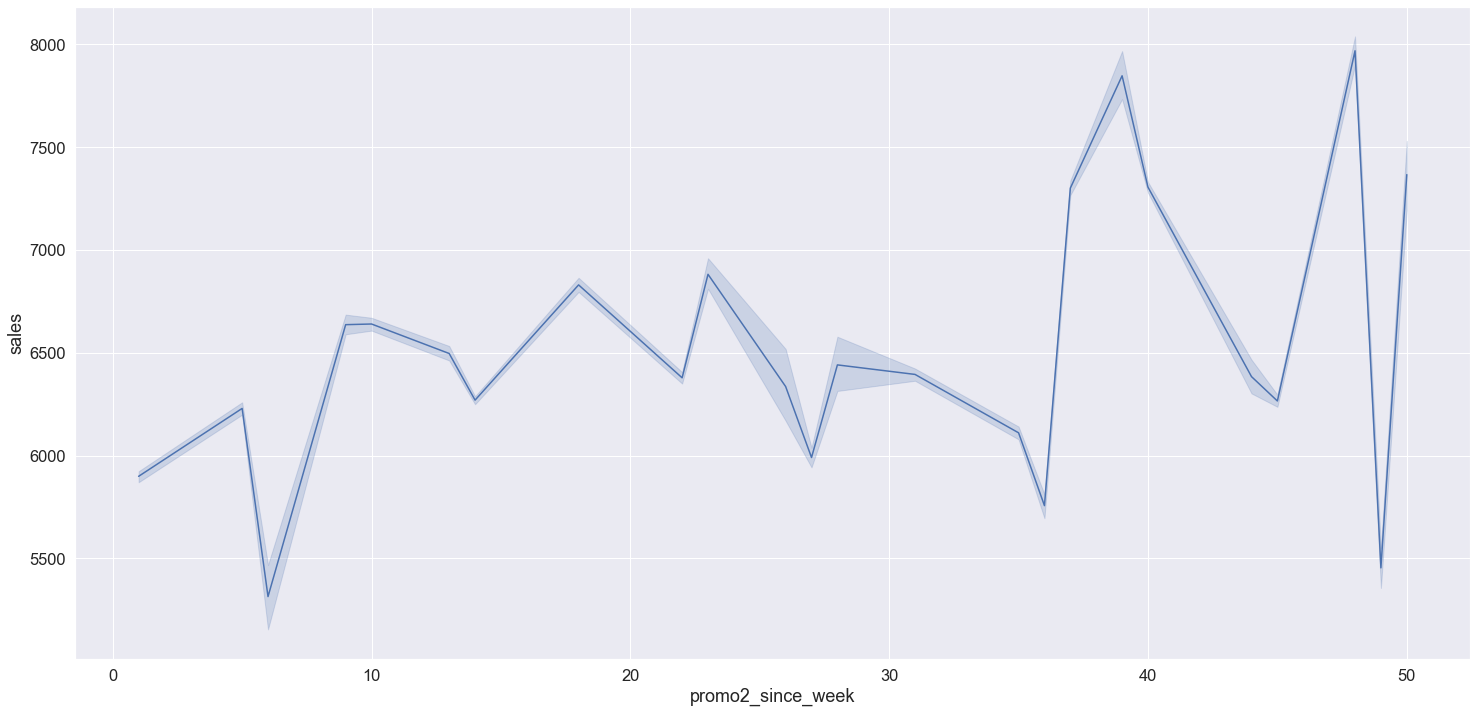

In [35]:
aux2 = df5[df5['promo2']==1]
sns.lineplot(x='promo2_since_week', y='sales', data=aux2);

### H3 As vendas são maiores quando o feriado cai na sexta (5 dia da semana)

** FALSA ** R: Comparando os gráficos (vendas totais em qualquer dia e vendas nos feriados), vemos que o feriado com mais vendas é no sábado.

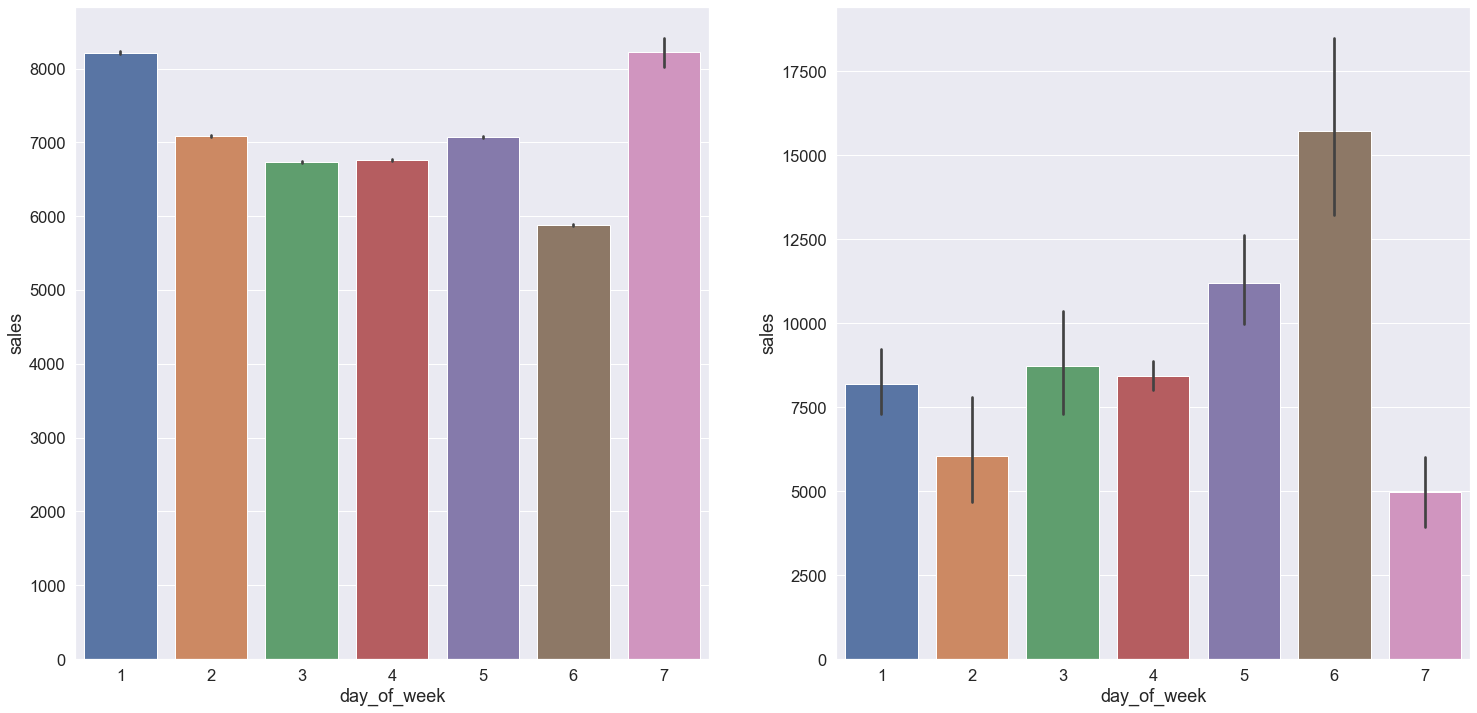

In [36]:
aux3 = df5[df5['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
sns.barplot(x='day_of_week', y='sales', data=df5);

plt.subplot(1,2,2)
sns.barplot(x='day_of_week', y='sales', data=aux3);


### H4 As vendas são maiores antes do feriado em comparação ao dia depois do feriado

In [37]:
date = df5[['date']]
r = date.head(1)
print(r)
# Diminuir 1 dia
r -= dt.timedelta(days=1)
print(r)
# Aumentar 1 dia
r += dt.timedelta(days=1)
print(r)

        date
0 2015-07-31
        date
0 2015-07-30
        date
0 2015-07-31


In [38]:
df5_feriado = df5[['sales', 'state_holiday']].groupby('state_holiday').mean().reset_index()
df5_feriado

,state_holiday,sales
0,christmas,9743.746479
1,easter_holiday,9887.889655
2,public_holiday,8487.471182
3,regular_day,6953.960229


### H5 Quanto maior o valor das vendas, maior é o ticket médio (gastos por clientes)

**FALSA** O ticket médio se manteve constante mesmo com o aumento das vendas

<AxesSubplot:xlabel='ticket_medio', ylabel='sales'>

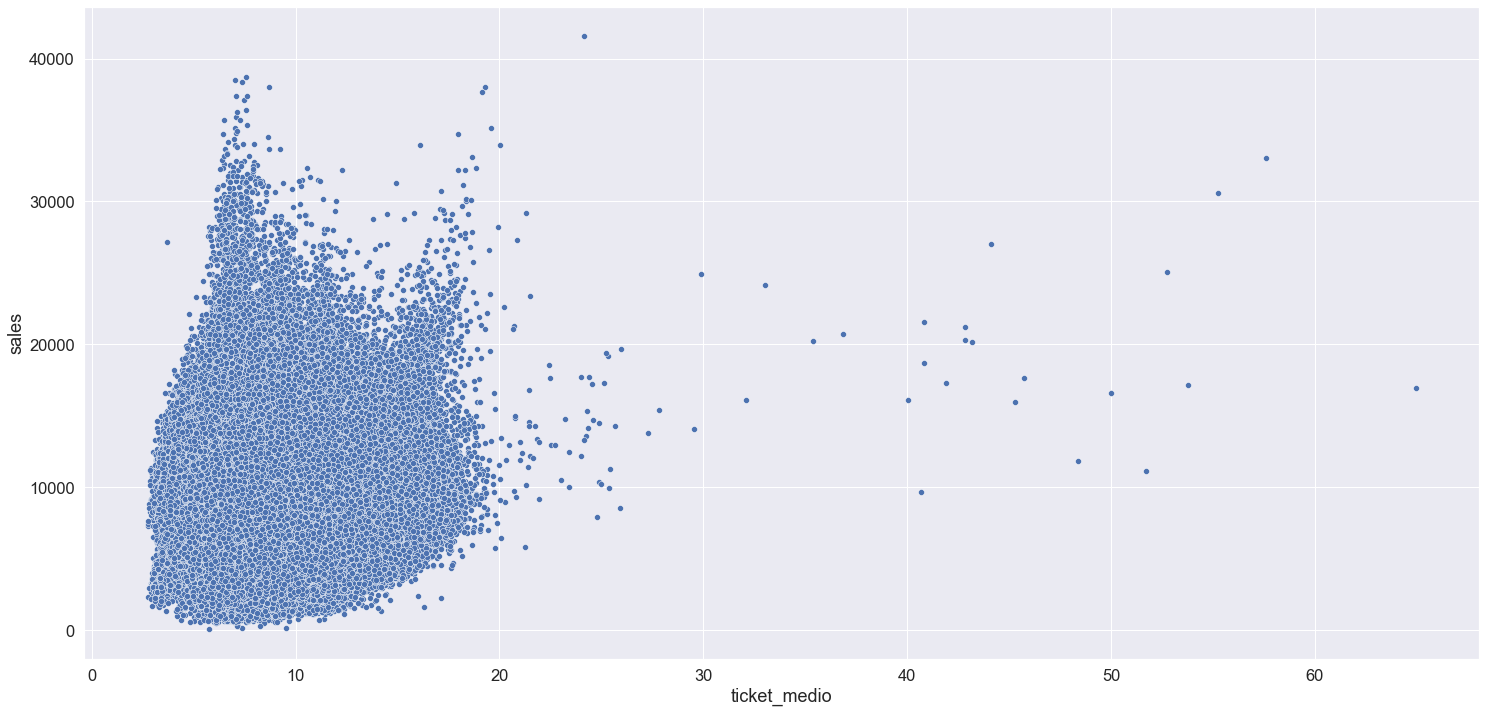

In [39]:
sns.scatterplot(x='ticket_medio', y='sales', data=df5)

## 5.3 Multivariate Analysis

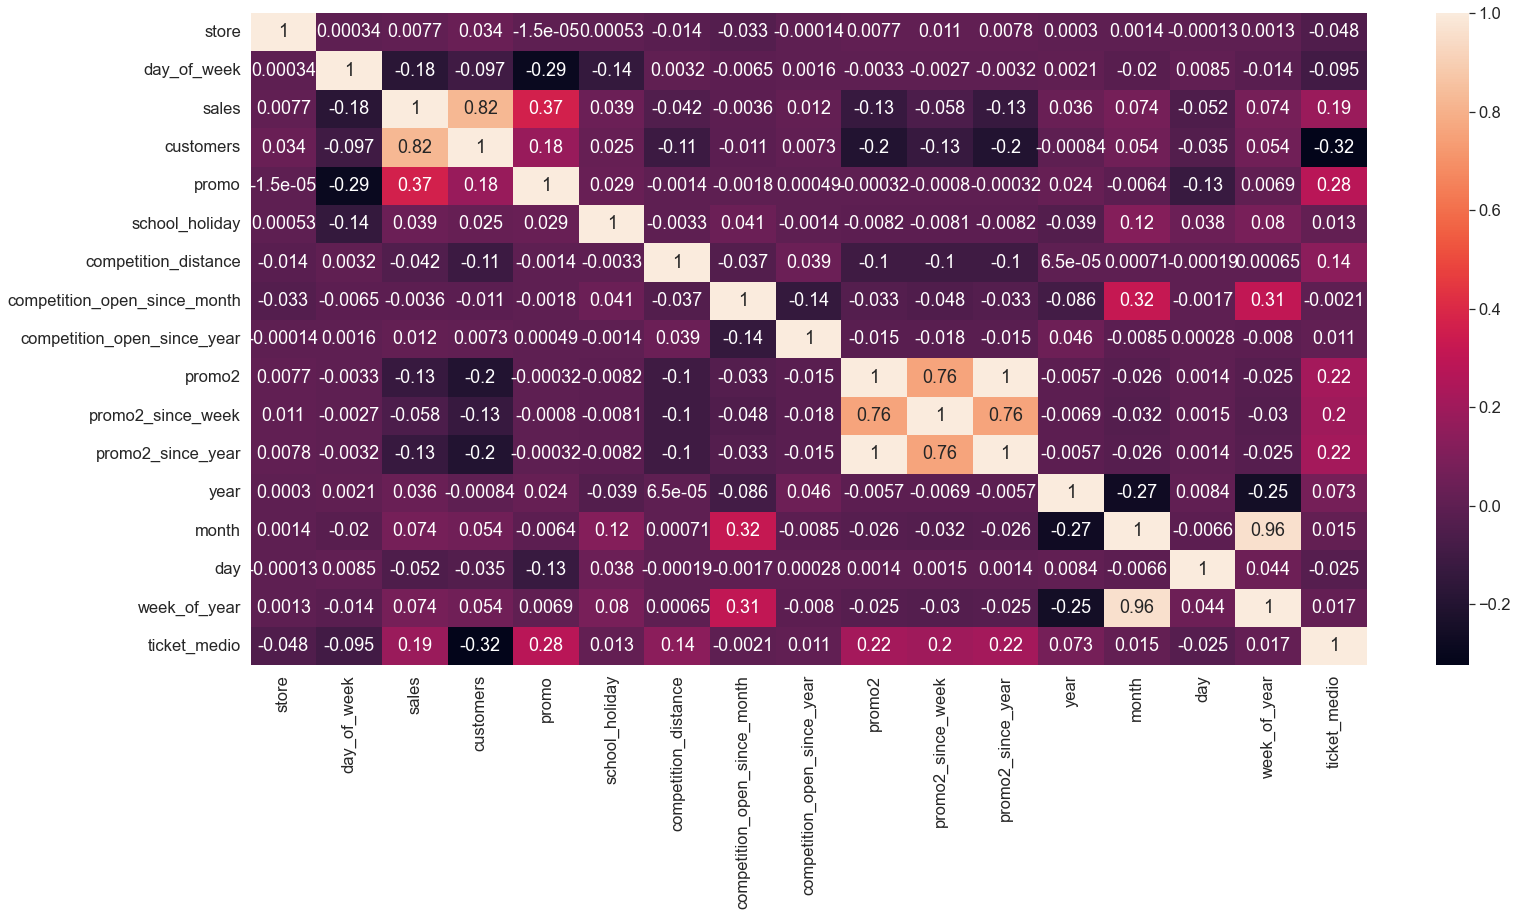

In [40]:
correlation = num_atrib.corr(method='pearson')

sns.heatmap(correlation, annot=True);

# 6.0 Data Preparation

In [41]:
df6 = df5.copy()

## 6.1 Standardization

## 6.2 Rescaling

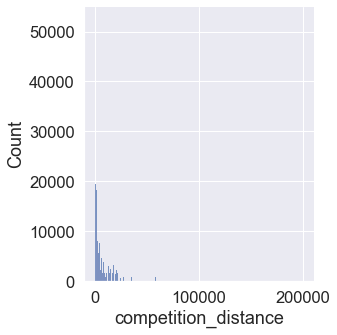

In [42]:
sns.displot(df6['competition_distance']);

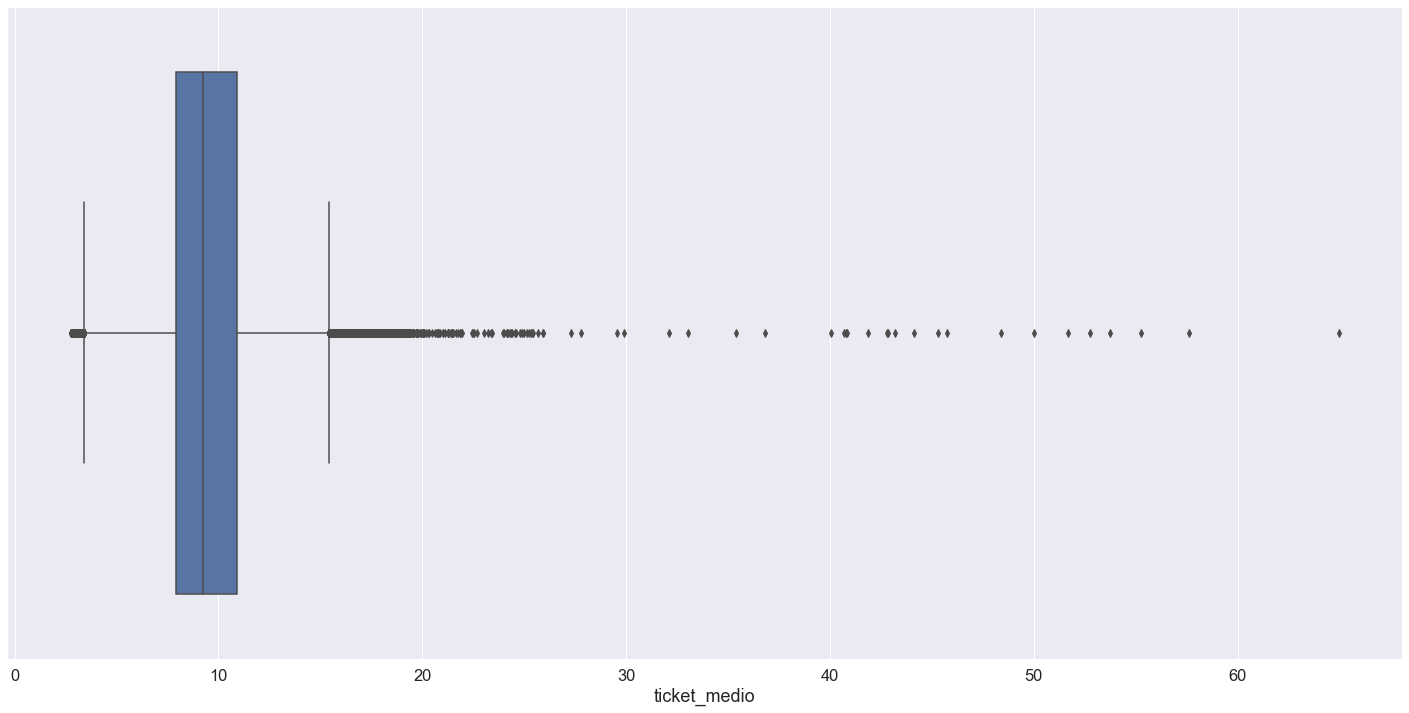

In [43]:
sns.boxplot(df6['ticket_medio']);

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()

In [45]:
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)

df6['ticket_medio'] = mms.fit_transform(df6[['ticket_medio']].values)

df6['year'] = mms.fit_transform(df6[['year']].values)

df6['customers'] = mms.fit_transform(df6[['customers']].values)


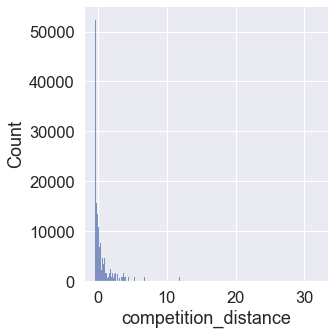

In [46]:
sns.displot(df6['competition_distance']);

## 6.3 Encoder

### 6.3.1 Encoding

In [47]:
cat_atrib.sample()

,state_holiday,store_type,assortment,year_week
890104,regular_day,a,basic,2013-16


In [48]:
df6 = pd.get_dummies(df6, prefix=['state_holiday'], columns=['state_holiday'])

le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])

assortm_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df6['assortment'] = df6['assortment'].map(assortm_dict)


### 6.3.2 Response Variable Transformation

In [49]:
df6['sales'] = np.log1p(df6['sales'])

### 6.3.3 Nature Transformation

In [50]:
# day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

# week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [51]:
df6.sample(3).T

,198649,731890,507825
store,180,121,171
day_of_week,2,5,3
date,2015-02-03 00:00:00,2013-09-13 00:00:00,2014-04-02 00:00:00
sales,8.873188,8.563313,9.208238
customers,0.106233,0.088753,0.127913
promo,1,1,1
school_holiday,0,0,0
store_type,3,0,0
assortment,1,1,1
competition_distance,0.559677,0.2,0.05


## 6.4 Validation Preparation

# 7.0 Feature Selection

In [52]:
df7 = df6.copy()

## 7.1 Split Dataset into Training and Test

In [53]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'year_week']
df7 = df7.drop(cols_drop, axis=1)

In [54]:
# Identificação dos dados 6 semana antes da última data de venda

df7[['store', 'date']].groupby('store').max().reset_index()['date'][0] - dt.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [55]:
X_train = df7[df7['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))




Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 7.2 Feature Selector (Boruta)

In [56]:
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
#rf = RandomForestRegressor(n_jobs=-1)
#
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [57]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [58]:
#cols_selected_boruta

In [59]:
# ['store', 'customers', 'competition_distance', 'ticket_medio']

In [60]:
cols_selected_boruta = [
    'store',
    'customers',
    'competition_distance',
    'ticket_medio'
]

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 8.0 Machine Learning Models

In [61]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 8.1 Average Model

In [62]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 8.2 Linear Regression Model

In [63]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)


# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1008.31526,0.132875,3921.113382


### 8.2.1 Linear Regression Model - Cross Validation

In [64]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1104.99 +/- 190.42,0.13 +/- 0.0,4442.42 +/- 1362.34


## 8.3 XGBoost Regressor

In [66]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                            colsample_bytree = 0.9).fit(x_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6677.736109,0.950774,7310.797238


### 8.3.1 XGBoost Regressor - Cross Validation

In [67]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, False)
xgb_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7040.02 +/- 587.18,0.95 +/- 0.0,7691.87 +/- 687.1


# 9.0 Hyperparameter Fine Tunning

# 10.0 Convert Model Performance to Business Values

# 11.0 Model's Deploy to Production